In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# import optimizer
from torch.optim import AdamW
from mnist_svd import MnistSVD
from unet import *

# test

In [2]:
mnist = MnistSVD("data")
mnist_test = MnistSVD("data", train=False)

U, S, Vh, label = mnist[np.random.randint(len(mnist))]
# plot test_figure
plt.imshow(U @ torch.diag(S) @ Vh, cmap='gray')
plt.title(f"digit:{label}")
plt.show()

plt.figure(figsize=(30,10))
l_ranks = 1
u_ranks = 10
for jj, ii in enumerate(range(l_ranks - 1, u_ranks,2)):
    lr_image = U[:,:(ii+1)] @ torch.diag(S[:(ii+1)]) @ Vh[:(ii+1),:]
    plt.subplot(1,u_ranks - l_ranks + 1,jj+1)
    plt.imshow(lr_image, cmap='gray')
    plt.title(f"rank:{ii+1}")
plt.show()

plt.figure(figsize=(30,10))
for jj, ii in enumerate(range(l_ranks - 1, u_ranks,2)):
    lr_image = U[:,ii:(ii+1)] @ torch.diag(S[ii:(ii+1)]) @ Vh[ii:(ii+1),:]
    plt.subplot(1,u_ranks - l_ranks + 1,jj+1)
    plt.imshow(lr_image, cmap='gray')
    plt.title(f"rank:{ii+1}")
plt.show()

KeyboardInterrupt: 

In [13]:
# dataloader
mnist_train = MnistSVD("data", train_preprocess = True)
train_dataloader = DataLoader(mnist_train, batch_size = 64, shuffle = True, num_workers=12,pin_memory=True)

Done!


tensor(27.)


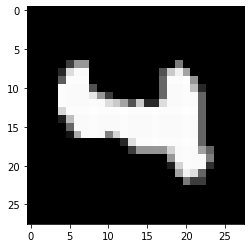

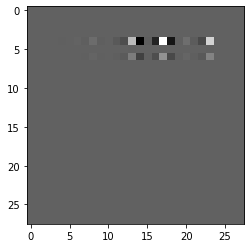

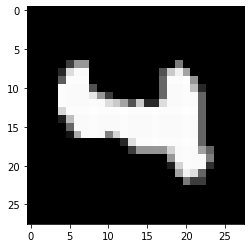

In [14]:
dt = iter(train_dataloader)
inp, out, rank_list = next(dt)

check_ind = 12
print(rank_list[check_ind])
plt.imshow(inp[check_ind][0].numpy(),cmap="gray")
plt.show()
plt.imshow(out[check_ind][0].numpy(),cmap="gray")
plt.show()
plt.imshow(inp[check_ind][0].numpy()+ out[check_ind][0].numpy(),cmap="gray")
plt.show()

In [18]:
inp


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [-0., -0., -0.,  ..., -0., -0., -0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 

In [26]:
lr = 2e-5
wd = 1e-5
net = UNet(ranks=28, channels=[64, 128, 256, 512], embed_dim=256).cuda()

optimizer = AdamW(net.parameters(), lr = lr, weight_decay=wd)

ema_decay = 0.995
ema_net = UNet(ranks=28, channels=[64, 128, 256, 512], embed_dim=256).cuda()
ema_net.load_state_dict(net.state_dict())

<All keys matched successfully>

In [25]:
epoch = 1000
total_loss_frac = 0
total_loss = 0
steps = 0
for ep in range(epoch):
    for inp, out, rank_list in train_dataloader:
        steps += 1
        optimizer.zero_grad()
        est_out = net(inp.cuda(),rank_list.cuda())
        # est_sig, leftv, rightv = net(inp.cuda(),rank_list.cuda())
        # loss1 = torch.sum(torch.pow(sig.cuda() - est_sig,2))
        # loss2 = torch.sum(torch.pow(leftv - lv.cuda(),2)) / len(lv)
        # loss3 = torch.sum(torch.pow(rightv - rv.cuda(),2))/ len(lv)
        # loss =  loss2 + loss3
        loss = torch.sum(torch.pow(out.cuda() - est_out,2)) 
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        total_loss += loss.item()
        loss_frac = loss.item() / torch.sum(torch.pow(out.cuda(),2)).item()
        total_loss_frac += loss_frac
        # total_loss1 += loss1.item()
        # total_loss2 += loss2.item()
        # total_loss3 += loss3.item()

        if steps % 10 == 0:
            for param, ema_param in zip(net.parameters(), ema_net.parameters()):
                ema_param.data.mul_(ema_decay).add_(param.data, alpha=1 - ema_decay)


        if steps % 1000 == 0:
            print(f"epoch:{ep},steps:{steps},avg_loss:{total_loss/steps},loss:{loss.item()},avg_loss_frac:{total_loss_frac/steps},loss_frac:{loss_frac}")
            torch.save(net.state_dict(), "model.pth")
            torch.save(ema_net.state_dict(), "ema_model.pth")
            # print(f"epoch:{ep},steps:{steps},avg_loss:{total_loss/steps} avg_loss1:{total_loss1/steps} avg_loss2:{total_loss2/steps} avg_loss3:{total_loss3/steps}")

epoch:1,steps:1000,avg_loss:5058.29717602539,loss:902.8765258789062,avg_loss_frac:12.497267126960732,loss_frac:1.1970940178271792


KeyboardInterrupt: 

In [23]:
est_out = net(inp.cuda(),rank_list.cuda())

In [1]:
a=1
b=2

In [25]:
est_out[0]

tensor([[[ 5.6479e-02, -1.1676e+00, -4.4864e-01, -9.7046e-01,  4.1485e-01,
          -1.2377e+00, -2.3049e-01,  2.4770e-01, -3.0986e-01,  1.0057e-01,
          -2.4581e-01,  1.0667e+00,  1.7366e+00, -1.6785e+00, -3.5666e-01,
          -5.7569e-01, -2.3749e+00,  1.1727e+00, -3.2671e-02, -8.8155e-01,
           9.3106e-01, -4.5995e-01,  3.6894e-01,  6.0930e-01, -8.7397e-01,
          -4.8547e-01,  1.2009e+00, -7.6524e-01],
         [ 3.3278e-01, -1.6700e+00, -5.0386e-01,  1.4001e-02, -1.3127e+00,
           1.0066e+00, -4.6002e-01,  2.4699e+00, -2.2349e+00, -8.4504e-01,
          -7.4788e-01, -7.5410e-01, -1.3303e+00, -1.1380e+00,  6.1257e-01,
           3.3882e-01,  1.2066e+00,  4.6660e-01, -2.1805e-01,  8.0181e-02,
          -8.7942e-02, -3.2966e-01, -9.9576e-01, -3.4315e-01,  1.6682e+00,
           8.9445e-01,  2.7336e+00, -3.5397e-01],
         [ 5.1443e-01,  1.4704e+00,  1.1699e+00, -1.7487e+00,  6.0826e-01,
          -1.2505e+00,  8.3210e-01, -3.9437e-01, -7.5772e-01,  1.4503e+00,


# inference

Done!


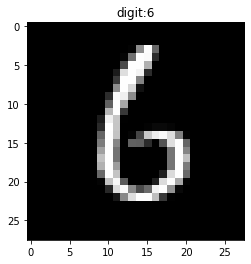

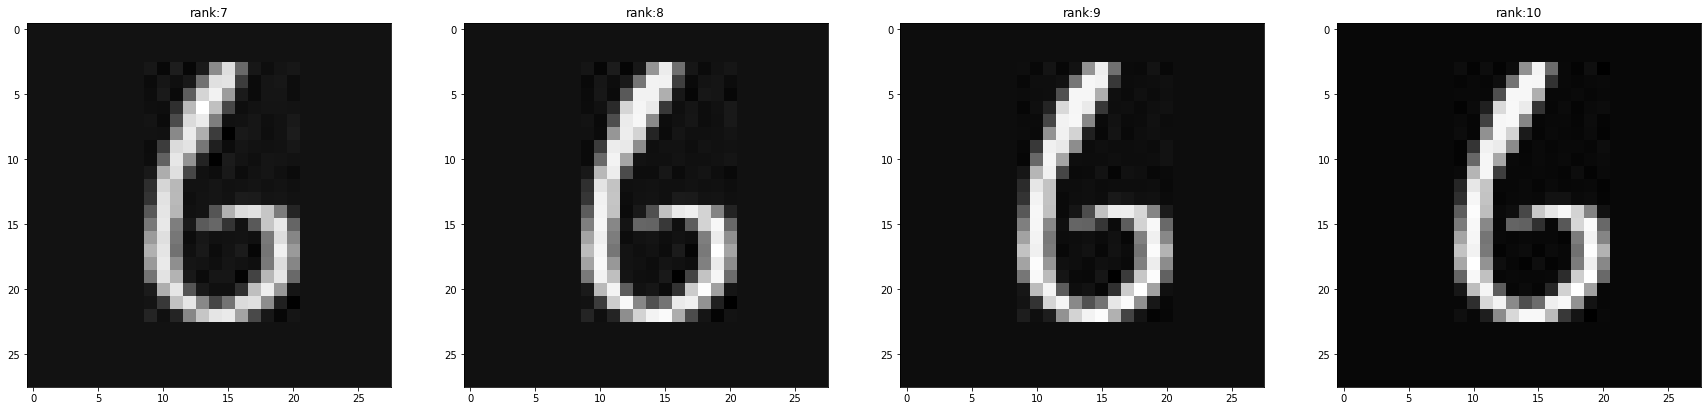

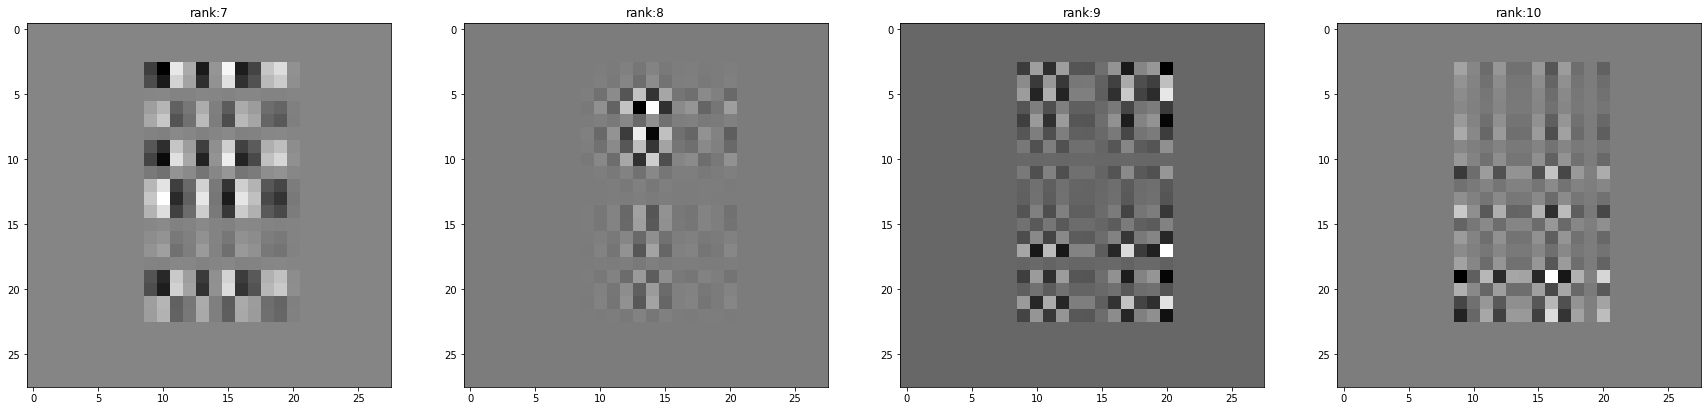

In [8]:
mnist = MnistSVD("data", train=True)

U, S, Vh, label = mnist[np.random.randint(len(mnist))]
# plot test_figure
plt.imshow(U @ torch.diag(S) @ Vh, cmap='gray')
plt.title(f"digit:{label}")
plt.show()

plt.figure(figsize=(30,10))
l_ranks = 7
u_ranks = 10
for jj, ii in enumerate(range(l_ranks - 1, u_ranks,1)):
    lr_image = U[:,:(ii+1)] @ torch.diag(S[:(ii+1)]) @ Vh[:(ii+1),:]
    plt.subplot(1,u_ranks - l_ranks + 1,jj+1)
    plt.imshow(lr_image, cmap='gray')
    plt.title(f"rank:{ii+1}")
plt.show()

# plot test_figure with figsize = (20,10)
plt.figure(figsize=(20,10))
l_ranks = 7
u_ranks = 10
for jj, ii in enumerate(range(l_ranks - 1, u_ranks,1)):
    lr_image = U[:,:(ii+1)] @ torch.diag(S[:(ii+1)]) @ Vh[:(ii+1),:]
    plt.subplot(1,u_ranks - l_ranks + 1,jj+1)
    plt.imshow(lr_image, cmap='gray')
    plt.title(f"rank:{ii+1}")  



plt.figure(figsize=(30,10))
for jj, ii in enumerate(range(l_ranks - 1, u_ranks,1)):
    lr_image = U[:,ii:(ii+1)] @ torch.diag(S[ii:(ii+1)]) @ Vh[ii:(ii+1),:]
    plt.subplot(1,u_ranks - l_ranks + 1,jj+1)
    plt.imshow(lr_image, cmap='gray')
    plt.title(f"rank:{ii+1}")
plt.show()

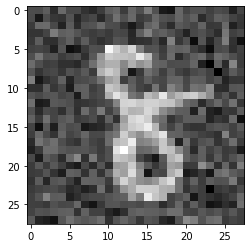

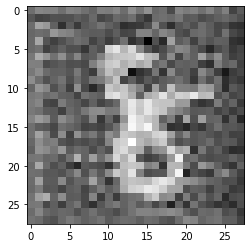

In [33]:
now_fig = inp[0][0]
plt.imshow(now_fig,cmap="gray")
plt.show()
now_fig = now_fig.unsqueeze(0).unsqueeze(0).cuda()
with torch.no_grad():
    for now_rank in range(1,5):
        infer_fig = now_fig - 0.2 * net(now_fig,torch.FloatTensor([8]).cuda())
plt.imshow(infer_fig.cpu()[0][0],cmap="gray")
plt.show()


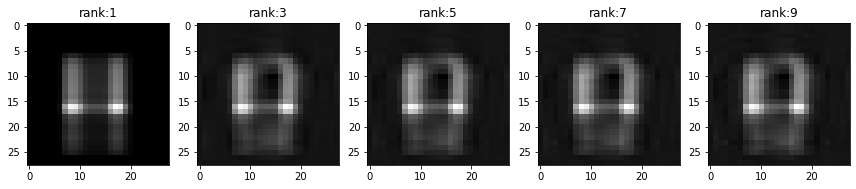

In [28]:
plt.figure(figsize=(30,10))
for jj, ii in enumerate(range(l_ranks - 1, u_ranks,2)):
    lr_image = infer_fig[ii]
    plt.subplot(1,u_ranks - l_ranks + 1,jj+1)
    plt.imshow(lr_image, cmap='gray')
    plt.title(f"rank:{ii+1}")
plt.show()

# test trained

In [36]:

net = UNet_MLP(28*28, scale = 12, block_layer = 2).cuda()
net.load_state_dict(torch.load("model.pth"))



<All keys matched successfully>

In [39]:
mnist = MnistSVD("data", train=False)

Done!


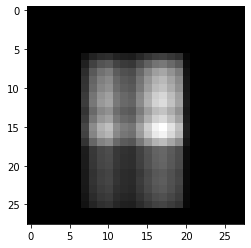

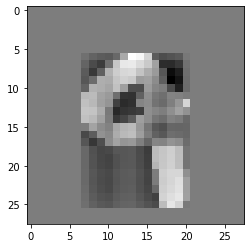

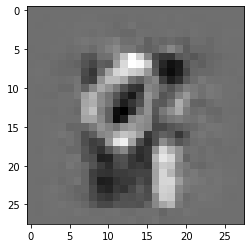

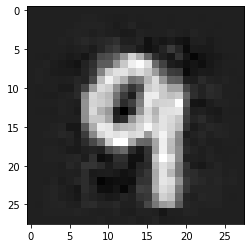

In [43]:
test_U, test_S, test_Vh, test_label = mnist[np.random.randint(len(mnist))]
inp = test_U[:,:1] @ torch.diag(test_S[:1]) @ test_Vh[:1,:]
out = test_U[:,1:] @ torch.diag(test_S[1:]) @ test_Vh[1:,:]

inp_flat = inp.flatten().unsqueeze(0).cuda()
out_flat = out.flatten().unsqueeze(0).cuda()

with torch.no_grad():
    est_out = net(inp_flat)

plt.imshow(inp,cmap="gray")
plt.show()
plt.imshow(out,cmap="gray")
plt.show()
plt.imshow(est_out.cpu().reshape(28,28),cmap="gray")
plt.show()
plt.imshow(est_out.cpu().reshape(28,28)+inp,cmap="gray")
plt.show()

In [5]:
now_fig = test_U[:,:1] @ torch.diag(test_S[:1]) @ test_Vh[:1,:]
plt.imshow(now_fig,cmap="gray")
plt.show()
now_fig = .unsqueeze(0).unsqueeze(0).cuda()
with torch.no_grad():
    for now_rank in range(1,2):
        for now_step in range(1,2):
            print(now_rank, now_step)
            now_fig = now_fig + net(now_fig.view(inp.shape[0],-1).cuda()).view(*inp.shape)
            #now_U, now_S, now_Vh = torch.svd(now_fig[0][0])
            #now_fig = now_U[:,:(now_rank+1)] @ torch.diag(now_S[:(now_rank+1)]) @ now_Vh[:(now_rank+1),:]
            plt.imshow(now_fig.cpu()[0][0],cmap="gray")
            plt.show()

NameError: name 'test_U' is not defined

In [16]:
# test MLP
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, output_dim)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return x
    
net = MLP(784, 784, 784, 784).cuda()


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)